## Model 1 - ERC (Emotion Recognition in conversation)

#### Setup

In [8]:
! pip install transformers
! pip install sentence_transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

import pickle
import os

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# disable CUDNN 

torch.backends.cudnn.enabled = False

DEVICE

device(type='cuda')

### Data *engneering*

### **Models**

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ERC_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, mlp_hidden_size, output_size):
        super(ERC_CNN, self).__init__()
        """
        ERC-CNN Module combining CNN, BiLSTM, and MLP
        Input shape: (batch_size, in_channels, width, length)
        Output shape: (batch_size, seq_length, output_size)
        """
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))

        # BiLSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # MLP layers
        self.fc1 = nn.Linear(hidden_size * 2, mlp_hidden_size)
        self.fc2 = nn.Linear(mlp_hidden_size, output_size)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        # BiLSTM
        x = x.squeeze(1)  # Remove the singleton dimension
        x, _ = self.bilstm(x)

        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### DataLoader

In [12]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, json_path = 'train_file.json'):
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.train_data = pd.read_json(json_path)
        emotions = ['surprise', 'neutral', 'disgust', 'fear', 'sadness', 'anger', 'joy']
        self.emotion_dict = {}
        for i, emotion in enumerate(emotions):
            self.emotion_dict[emotion] = i

    def generate_cnn_embeddings(self, row):
        speakers = row['speakers']

        embeddings_list = self.embedding_model.encode(row['utterances'])

        speaker_index = {}
        index = 0
        for speaker in speakers:
            if speaker not in speaker_index:
                speaker_index[speaker] = index
                index += 1

        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10 , S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_emotion_matrix(self, row):
        emotions = row['emotions']
        emotion_matrix = np.zeros((len(emotions), 7))
        for idx, emotion in enumerate(emotions):
            emotion_matrix[idx][self.emotion_dict[emotion]] = 1
        return emotion_matrix


    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        X = self.generate_cnn_embeddings(self.train_data.iloc[idx])
        Y = self.gen_emotion_matrix(self.train_data.iloc[idx])
        return X, Y

### Model

In [13]:
# Define parameters
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_emotions = 7


# Initialize the ERC_CNN class
model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

# input_tensor = torch.randn(batch_size, speakers, num_utterances, embedding_size)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define your model, loss function, and optimizer
folder_path = "/content/drive/MyDrive/IIITD/Courses/nlp/Assignment 4/"
folder_path = ""

path_train_file = folder_path+"train_file.json"

dataset = MyDataset(path_train_file)
criterion = nn.CrossEntropyLoss().to(DEVICE)

model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

val_dataset = MyDataset(folder_path+"val_file.json")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

train_losses = []
val_losses = []



num_epochs = 6
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in tqdm(enumerate(dataloader)):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs.float())

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * inputs.size(0)

        # tqdm.write(f"Training in Progress: {i+1}/{6000}")

    # Print average loss for the epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    train_losses.append(epoch_loss)


    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(val_dataloader)):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(val_dataloader.dataset)
    print(f"Validation Loss: {epoch_loss:.4f}")

    val_losses.append(epoch_loss)

    if epoch % 2 == 0:
        torch.save(model.state_dict(), folder_path+f"1_erc_cnn_model{epoch}.pth")

6740it [01:42, 65.79it/s]


Epoch [1/6], Loss: 2.8056


843it [00:11, 76.41it/s]


Validation Loss: 2.3971


6740it [01:42, 65.67it/s]


Epoch [2/6], Loss: 1.9802


843it [00:11, 76.37it/s]


Validation Loss: 1.6914


6740it [01:42, 65.49it/s]


Epoch [3/6], Loss: 1.6022


843it [00:11, 76.19it/s]


Validation Loss: 1.5536


6740it [01:42, 65.70it/s]


Epoch [4/6], Loss: 1.5261


843it [00:11, 76.60it/s]


Validation Loss: 1.5113


6740it [01:42, 65.61it/s]


Epoch [5/6], Loss: 1.4985


843it [00:11, 76.53it/s]


Validation Loss: 1.4969


6740it [01:42, 65.57it/s]


Epoch [6/6], Loss: 1.4870


843it [00:10, 76.64it/s]

Validation Loss: 1.4895


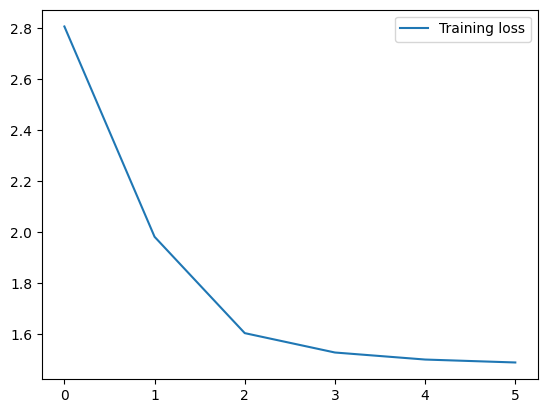

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
#plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()


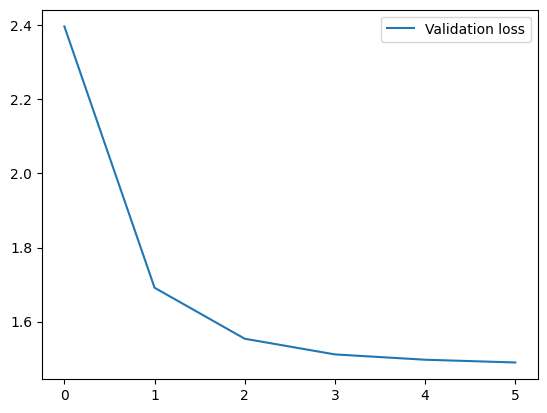

In [16]:
plt.plot(val_losses, label='Validation loss')
plt.legend()

plt.show()


In [17]:
# save the model
torch.save(model.state_dict(), folder_path+"M1.pth")

In [18]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

state_dict = torch.load('M1.pth')
model.load_state_dict(state_dict)

model = model.to(DEVICE)

l = ['surprise', 'neutral', 'disgust', 'fear', 'sadness', 'anger', 'joy']

model.eval()

ERC_CNN(
  (conv1): Conv2d(10, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (bilstm): LSTM(768, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
)

In [19]:
import torch
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def get_F1(model , dataloader , DEVICE):
    all_predicted=[]
    all_true=[]

    for inputs,labels in dataloader:
        inputs=inputs.to(DEVICE)
        labels=labels.to(DEVICE)
        with torch.no_grad():
            outputs=model(inputs.float())
        predicted=torch.argmax(outputs,dim=2).cpu().numpy().flatten()
        true_labels=torch.argmax(labels,dim=2).cpu().numpy().flatten()
        all_predicted.extend(predicted)
        all_true.extend(true_labels)

    f1_scores_dict = {
        'surprise': f1_score(all_true, all_predicted, labels=[0], average='macro'),
        'neutral': f1_score(all_true, all_predicted, labels=[1], average='macro'),
        'disgust': f1_score(all_true, all_predicted, labels=[2], average='macro'),
        'fear': f1_score(all_true, all_predicted, labels=[3], average='macro'),
        'sadness': f1_score(all_true, all_predicted, labels=[4], average='macro'),
        'anger': f1_score(all_true, all_predicted, labels=[5], average='macro'),
        'joy': f1_score(all_true, all_predicted, labels=[6], average='macro'),
        'overall': f1_score(all_true, all_predicted, average='macro')
    }    

    cm = confusion_matrix(all_true, all_predicted)

    print(f1_scores_dict)

    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=l, yticklabels=l)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return 

{'surprise': 0.9597597597597598, 'neutral': 0.9959660047781302, 'disgust': 0.8834173835657075, 'fear': 0.8479435957696826, 'sadness': 0.944555778223113, 'anger': 0.9622917275650396, 'joy': 0.9860460803857031, 'overall': 0.9399971900067338}


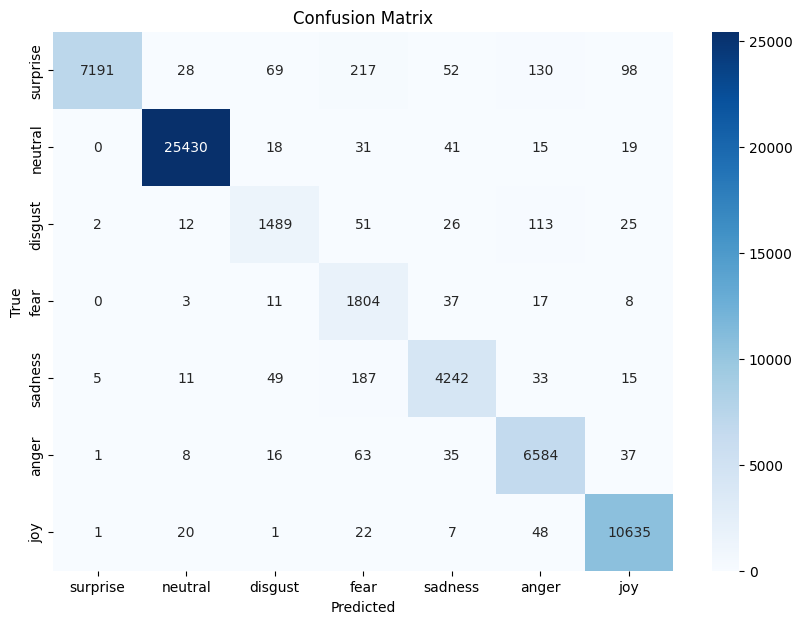

In [20]:
# TRAINING 
get_F1(model , dataloader , DEVICE)

{'surprise': 0.9419759539989545, 'neutral': 0.9911173445535297, 'disgust': 0.8373205741626795, 'fear': 0.8070175438596492, 'sadness': 0.9146005509641872, 'anger': 0.9389788293897884, 'joy': 0.9825119236883944, 'overall': 0.9162175315167403}


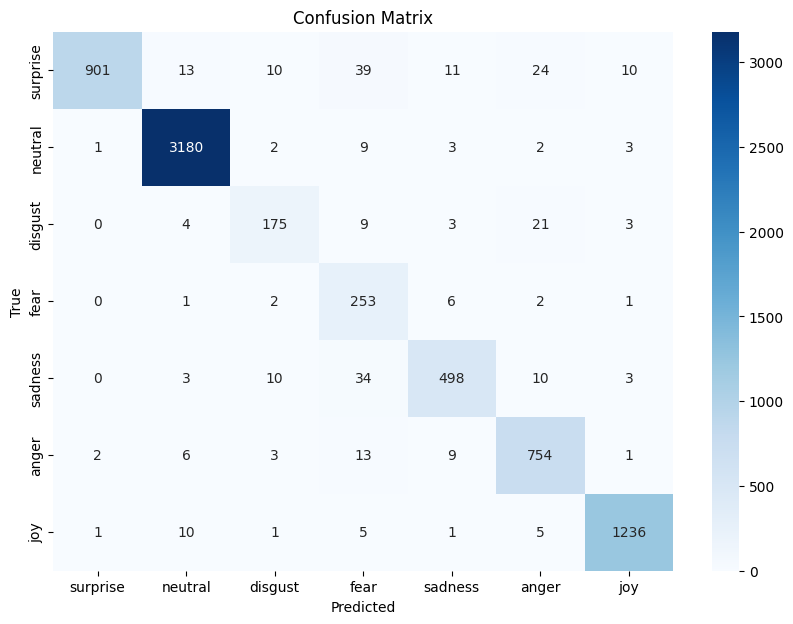

In [21]:
# VALIDATION
get_F1(model , val_dataloader , DEVICE)